In [29]:
import os, pickle
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('../data/eda_sample_data_file.csv')
df.columns

Index(['location', 'title', 'city', 'state', 'zip', 'country', 'job_type',
       'posted_at', 'job_reference', 'company', 'mobile_friendly_apply',
       'category', 'html_jobs', 'url', 'body', 'cpc'],
      dtype='object')

In [3]:
cols_to_show = ['title', 'city', 'state', 'zip', 'country', 'company', 'category', 'body']
df = df[cols_to_show]
df.head()

,title,city,state,zip,country,company,category,body
0,Retail Store Manager - Alabaster AL,Alabaster,AL,35007,United States,CVS Health,Retail,Job Description<br /> <br /> General Summary:<...
1,Financial Relationship Consultant - Pell City,Pell City,AL,35125,United States,Regions Financial Corporation,Accounting,Thank you for your interest in a career at Reg...
2,Prod Cook 3 PM Bob's Steak & Chop,Fort Worth,TX,76102,United States,Omni Hotels,Restaurant,Overview<br /> <br /> Job Description<br /> <b...
3,Quant Developer,Boston,MA,02298,United States,Ceres Group,Biotechnology/Pharmaceutical,We are looking for an Analyst to work in in co...
4,Human Resource Manager,Dulles,VA,20102,United States,Alpha Corporation,HR,Alpha Corporation established in 1979 is a ful...


## Labelled Data

Avoid tackling an unsupervised learning problem for the time being. Manually label a subset of the data instead.

Considerations for the future:
    + Larger sample size
    + Ensure a representative sample

In [4]:
data = pd.read_csv('../data/labeled_eda_sample_data_file.csv')
data.columns

Index(['title', 'city', 'state', 'zip', 'country', 'posted_at',
       'job_reference', 'company', 'category', 'body', 'gig'],
      dtype='object')

In [5]:
data.gig.value_counts()

0    793
1    207
Name: gig, dtype: int64

In [6]:
# omitting for now...
# date (later may be interesting for seasonal labor)
# location (some areas have more service industry roles)
# job ref (index for future)
# category (keep it simple)
cols_to_train = ['title', 'company', 'body', 'gig'] 
data = data[cols_to_train]
data.head()

,title,company,body,gig
0,Retail Store Manager - Alabaster AL,CVS Health,Job Description<br /> <br /> General Summary:<...,0
1,Financial Relationship Consultant - Pell City,Regions Financial Corporation,Thank you for your interest in a career at Reg...,0
2,Prod Cook 3 PM Bob's Steak & Chop,Omni Hotels,Overview<br /> <br /> Job Description<br /> <b...,1
3,Quant Developer,Ceres Group,We are looking for an Analyst to work in in co...,0
4,Human Resource Manager,Alpha Corporation,Alpha Corporation established in 1979 is a ful...,0


In [20]:
data.dtypes

title      object
company    object
body       object
gig         int64
dtype: object

** Cleanup text **

In [7]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [8]:
text_cols = ['title', 'company', 'body']

for col in text_cols:
    data = standardize_text(data, col)

col_names = {'title':'job_title',
             'body':'description',
             'gig':'class_label'}    

data = data.rename(columns=col_names)

data.to_csv('../data/cleaned_labeled_data.csv')
data.head()

,job_title,company,description,class_label
0,retail store manager alabaster al,cvs health,job description br br general summary ...,0
1,financial relationship consultant pell city,regions financial corporation,thank you for your interest in a career at reg...,0
2,prod cook 3 pm bob's steak chop,omni hotels,overview br br job description br b...,1
3,quant developer,ceres group,we are looking for an analyst to work in in co...,0
4,human resource manager,alpha corporation,alpha corporation established in 1979 is a ful...,0


## NLP pipeline

** prep **

In [9]:
import keras
import nltk
import re
import codecs

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


** Begin with the simplest possible model. Use job title only**

In [10]:
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [12]:
df_title = data[['job_title','class_label']].copy()

In [13]:
tokenizer = RegexpTokenizer(r'\w+')

df_title['tokens'] = df_title['job_title'].apply(tokenizer.tokenize)
df_title.head()

,job_title,class_label,tokens
0,retail store manager alabaster al,0,"[retail, store, manager, alabaster, al]"
1,financial relationship consultant pell city,0,"[financial, relationship, consultant, pell, city]"
2,prod cook 3 pm bob's steak chop,1,"[prod, cook, 3, pm, bob, s, steak, chop]"
3,quant developer,0,"[quant, developer]"
4,human resource manager,0,"[human, resource, manager]"


In [14]:
all_words = [word for tokens in df_title['tokens'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df_title['tokens']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

4591 words total, with a vocabulary size of 1594
Max sentence length is 23


## Bag of words

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = df_title['job_title'].tolist()
list_labels = df_title['class_label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [28]:
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
X_test_counts

<200x1379 sparse matrix of type '<class 'numpy.int64'>'
	with 653 stored elements in Compressed Sparse Row format>

In [31]:
cv_file = '../models/CV_lr_bow_train_only_model.pckl'
pickle.dump(count_vectorizer, open(cv_file, 'wb'))

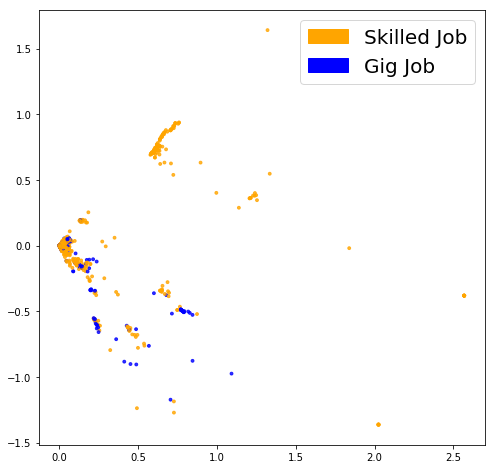

In [16]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Skilled Job')
            blue_patch = mpatches.Patch(color='blue', label='Gig Job')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})


fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

** Fit a classifier **

In [20]:
from sklearn.linear_model import LogisticRegression

#clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
#                         multi_class='multinomial', n_jobs=-1, random_state=40) # look into multi-class
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='ovr', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

** Save model **

In [27]:
import pickle

filename = '../models/lr_bow_train_only_model.pckl'
#pickle.dump(clf, open(filename, 'wb'))

In [21]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.900, precision = 0.899, recall = 0.900, f1 = 0.899


In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_predicted_counts)
print('confusion matrix')
print(cm)

confusion matrix
[[144   9]
 [ 11  36]]


In [23]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

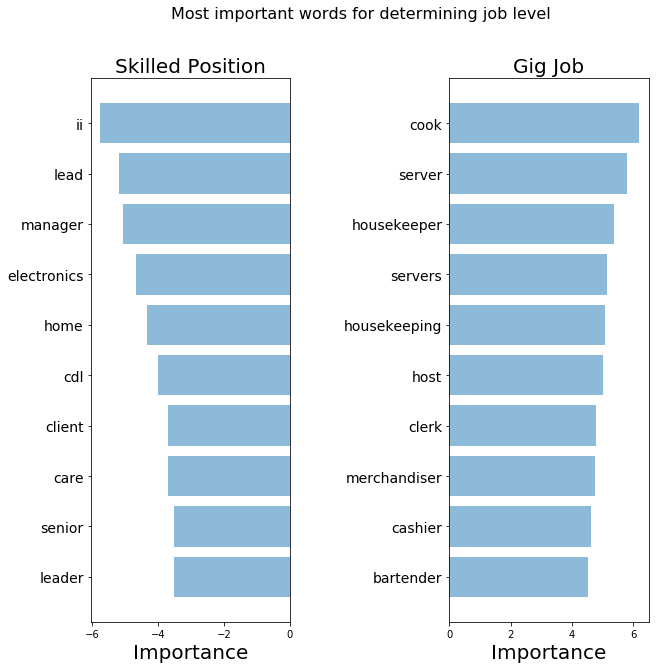

In [25]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name, save_png=False):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Skilled Position', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Gig Job', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    if save_png:
        plt.savefig('../images/important_words.png')
    else:
        plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for determining job level")

In [ ]:
X_sample = 

In [ ]:
filename = '../models/lr_bow_model.pckl'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

## TFIDF

**H0: Will be less effective as common words are likely important**